# Feature-embedding autoencoders
Linear, FEAs (as described in the accompanying draft) deployed on synthetic data.

In [53]:
import typing
import gc
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn, optim, tensor, FloatTensor
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
import torch.nn.functional as F

from fastai.basics import DataBunch # used for easy batching

from linear_models import LinearMLP, LinearAE, LinearFEA

import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(123)

### Load data, set model paramaters 

In [5]:
synthetic_expression_data = pd.read_csv("data/net1_expression_data.tsv", sep='\t')
tfs = pd.read_csv("data/net1_transcription_factors.tsv", sep='\t')
X_bool = [g in tfs.iloc[:,0].tolist() for g in synthetic_expression_data.columns]
not_X = [not(e) for e in X_bool]
X_idx = [i for (i, e) in enumerate(X_bool) if e]

In [6]:
np.mean(synthetic_expression_data.iloc[:,5])

0.22875542161490708

In [9]:
# NORMALIZE
z_transform = StandardScaler(copy=False)
z_transform.fit_transform(synthetic_expression_data)

array([[-1.513502, -0.662902,  1.035722, -0.099333, ...,  0.269878,  0.808098, -0.503824,  0.316177],
       [-1.451674, -0.530501,  0.860751, -0.112546, ...,  0.342414,  0.252326,  0.127953, -0.285483],
       [ 0.789257,  0.109032, -0.960121,  0.214051, ..., -1.190279, -0.242486,  2.060344, -0.387359],
       [ 1.009465, -0.722949, -1.638751, -0.435952, ..., -0.728643, -1.364042,  1.737365, -1.292079],
       ...,
       [-0.257406, -0.59743 ,  0.253681, -0.644706, ...,  0.061519,  0.150176, -0.393308,  0.205586],
       [-0.412048, -0.719399, -1.460654,  0.82438 , ..., -0.86137 , -1.363956,  0.424365, -1.38834 ],
       [-0.030537, -0.691725,  0.682982, -0.003222, ..., -0.275834, -0.387035,  0.29841 ,  0.234339],
       [-0.58073 , -0.732834, -1.384873,  1.397727, ...,  0.274279, -1.360667,  0.361357, -1.497163]])

In [10]:
np.mean(synthetic_expression_data.iloc[:,5])

-2.4273199047705285e-17

In [11]:
synthetic_expression_data.values.shape

(805, 1643)

In [12]:
train, valid, test = map(torch.FloatTensor, (
    synthetic_expression_data.values[:500, :], 
    synthetic_expression_data.values[500:700, :],
    synthetic_expression_data.values[700:, :]))

In [13]:
batch_size = 128
train_ds = TensorDataset(train[:, X_bool], train)
valid_ds = TensorDataset(valid[:, X_bool], valid)
test_ds = TensorDataset(test[:, X_bool], test)
train_dl = DataLoader(train_ds, batch_size)
valid_dl = DataLoader(valid_ds, batch_size)
test_dl = DataLoader(test_ds, batch_size)

In [14]:
# these also give us some shape values for later
X, Y = next(iter(train_ds))
X.shape, Y.shape

(torch.Size([194]), torch.Size([1643]))

In [92]:
input_dim = sum(X_bool)
hidden_dim = 512
output_dim = synthetic_expression_data.shape[1]

### First, train a simple linear autoencoder 

In [112]:
lae_model = LinearAE(input_dim, hidden_dim)
lae_model

LinearAE(
  (input): Linear(in_features=194, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=194, bias=True)
)

In [119]:
# train the linear AE
epochs = 100
lr = 1e-2
opt = optim.Adam(lae_model.parameters(), lr)
mse = nn.MSELoss()
train_loss, valid_loss = [], []

In [120]:
for e in tqdm(range(epochs)):
    this_train_loss = np.mean([lae_model.update_batch(X, opt, mse) for X, _ in train_dl])
    this_valid_loss = np.mean([lae_model.update_batch(X, opt, mse, train=False) for X, _ in valid_dl])
    train_loss.append(this_train_loss)
    valid_loss.append(this_valid_loss)

100%|██████████| 100/100 [00:02<00:00, 49.54it/s]


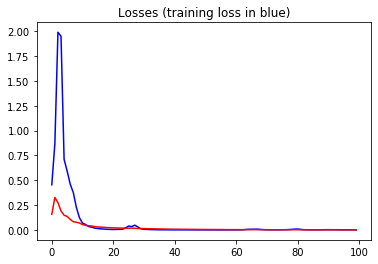

In [121]:
# plot losses
plt.plot([e for e in range(epochs)], train_loss, 'b')
plt.plot([e for e in range(epochs)], valid_loss, 'r')
plt.title("Losses (training loss in blue)")
plt.show()

### Final validation loss 

In [122]:
print("Final valid loss: {}".format(valid_loss[-1]))

Final valid loss: 0.0007916980248410255


### Visualise predicted vs. actual

In [123]:
# pick a row, generate predictions
idx = 10
X, Y = test_ds[idx]
# Y_hat, X_tilde = lfea_model(X)
X_tilde = lae_model(X)

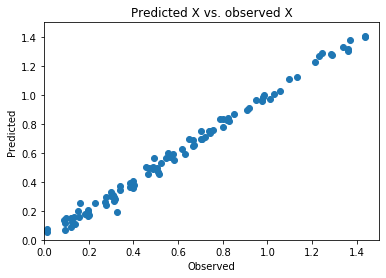

In [124]:
# X_tilde vs. X
plt.scatter(X.detach().numpy(), X_tilde.detach().numpy())
plt.title("Predicted X vs. observed X");
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)
plt.xlabel("Observed");
plt.ylabel("Predicted");

### Now a simple Linear MLP 

In [149]:
lmlp_model = LinearMLP(hidden_dim=512)
lmlp_model

LinearMLP(
  (input): Linear(in_features=194, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=1643, bias=True)
)

In [150]:
# train the linear MLP
epochs = 100
lr = 1e-2
opt = optim.Adam(lmlp_model.parameters(), lr)
mse = nn.MSELoss()
train_loss, valid_loss = [], []

In [151]:
for e in tqdm(range(epochs)):
    this_train_loss = np.mean([lmlp_model.update_batch(X, Y, opt, mse) for X, Y in train_dl])
    this_valid_loss = np.mean([lmlp_model.update_batch(X, Y, opt, mse, train=False) for X, Y in valid_dl])
    train_loss.append(this_train_loss)
    valid_loss.append(this_valid_loss)

100%|██████████| 100/100 [00:04<00:00, 21.62it/s]


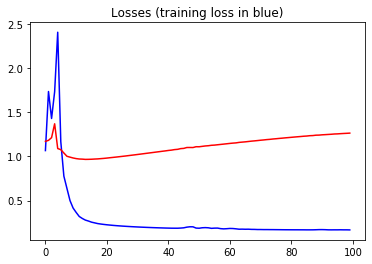

In [152]:
# plot losses
plt.plot([e for e in range(epochs)], train_loss, 'b')
plt.plot([e for e in range(epochs)], valid_loss, 'r')
plt.title("Losses (training loss in blue)")
plt.show()

### Now use these weights in a FEA

In [129]:
class joint_loss(nn.Module):
    """
    Parameters
    ----------
    lambda_ : float
        Weighting in the joint joss. 
        Higher lambda_ favours lower reconstruction loss.
    """
    def __init__(self, lambda_=0.5):
        super().__init__()
        self.X = X
        self.Y = Y
        self.lambda_ = lambda_
        
    def forward(self, X, X_tilde, Y, Y_hat):
        mse = nn.MSELoss()
        return ( ((1 - self.lambda_) * mse(Y_hat, Y)) + (self.lambda_ * mse(X_tilde, X)) )

In [130]:
lfea_model = LinearFEA(input_dim, hidden_dim, output_dim)
lfea_model

LinearFEA(
  (input): Linear(in_features=194, out_features=512, bias=True)
  (predict_Y): Linear(in_features=512, out_features=1643, bias=True)
  (reconstruct_X): Linear(in_features=512, out_features=194, bias=True)
)

### Copy the weights and biases from the trained AE

In [131]:
lfea_model.input.load_state_dict(lae_model.input.state_dict(), strict=True)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [132]:
lfea_model.reconstruct_X.load_state_dict(lae_model.output.state_dict(), strict=True)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [142]:
# train the linear FEA
epochs = 20
lr = 6e-4
opt = optim.Adam(lfea_model.parameters(), lr)
criterion = joint_loss(lambda_= 0.2)
train_loss, valid_loss = [], []

In [143]:
for e in tqdm(range(epochs)):
    this_train_loss = np.mean([lfea_model.update_batch(X, Y, opt, criterion) for X, Y in train_dl])
    this_valid_loss = np.mean([lfea_model.update_batch(X, Y, opt, criterion, train=False) for X, Y in valid_dl])
    train_loss.append(this_train_loss)
    valid_loss.append(this_valid_loss)

100%|██████████| 20/20 [00:01<00:00, 18.66it/s]


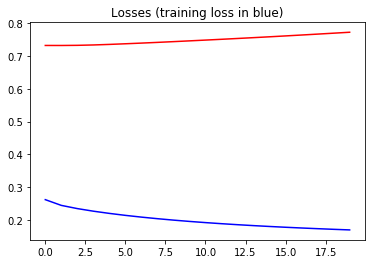

In [144]:
# plot losses
plt.plot([e for e in range(epochs)], train_loss, 'b')
plt.plot([e for e in range(epochs)], valid_loss, 'r')
plt.title("Losses (training loss in blue)")
plt.show()

### Final validation loss

In [145]:
print("Final valid loss: {}".format(valid_loss[-1]))

Final valid loss: 0.7729709148406982


### Visualise predicted vs. actual

In [146]:
# pick a row, generate predictions
idx = 10
X, Y = test_ds[idx]
Y_hat, X_tilde = lfea_model(X)
# X_tilde = lae_model(X)

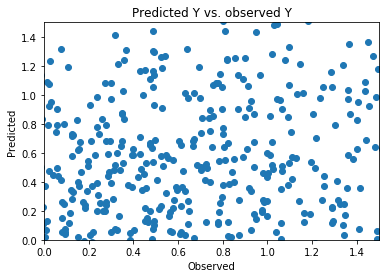

In [147]:
# Y_hat vs Y
plt.scatter(Y.detach().numpy(), Y_hat.detach().numpy())
plt.title("Predicted Y vs. observed Y");
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)
plt.xlabel("Observed");
plt.ylabel("Predicted");

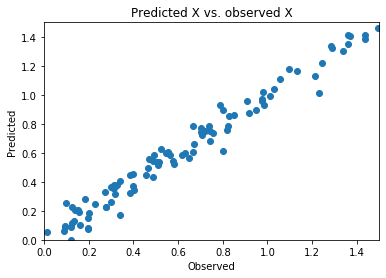

In [148]:
# X_tilde vs. X
plt.scatter(X.detach().numpy(), X_tilde.detach().numpy())
plt.title("Predicted X vs. observed X");
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)
plt.xlabel("Observed");
plt.ylabel("Predicted");

### Test loss 

In [28]:
# test losses
test_pred = []
pred_error = []
mse = nn.MSELoss()
for X, Y in test_ds:
    Y_hat, _ = lfea_model(X)
    test_pred.append(Y_hat.detach().numpy())
    pred_error.append(mse(Y_hat, Y).detach().numpy())
print("Final test MSE loss on prediction task: {}".format(np.mean(pred_error)))

Final test MSE loss on prediction task: 0.0359630212187767


In [29]:
gc.collect()

12444